<a href="https://colab.research.google.com/github/eagning1/DE1-G29/blob/main/DE1_G29.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#pip install nltk

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC  # Use LinearSVC instead of SVC for memory efficiency
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from collections import Counter, defaultdict
import random
from timeit import default_timer as timer
import re
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Download VADER lexicon if not already downloaded
try:
    nltk.data.find('vader_lexicon')
except LookupError:
    nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\erkoo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
# Set the style for our plots
plt.style.use('ggplot')
sns.set(font_scale=1.2)

In [5]:
class LyricsAnalyzer:
    def __init__(self, matches_file, train_file, sample_size=None):
        """
        Initialize the LyricsAnalyzer with the paths to the dataset files.
        
        Parameters:
        -----------
        matches_file : str
            Path to the mxm_779k_matches.txt file
        train_file : str
            Path to the mxm_dataset_train.txt file
        sample_size : int, optional
            If provided, only load a random sample of this many songs
        """
        self.matches_file = matches_file
        self.train_file = train_file
        self.sample_size = sample_size
        self.top_words = []
        self.matches_df = None
        self.lyrics_df = None
        self.word_counts = None
        self.sentiment_analyzer = SentimentIntensityAnalyzer()
        
    def load_matches(self):
        """Load and parse the matches file"""
        print("Loading matches data...")
        # Define column names based on the file format
        columns = ['msd_track_id', 'msd_artist_name', 'msd_title', 'mxm_track_id', 'mxm_artist_name', 'mxm_title']
        
        # Read the file
        data = []
        with open(self.matches_file, 'r', encoding='utf-8') as f:
            for line in f:
                if line.startswith('#'):  # Skip comment lines
                    continue
                parts = line.strip().split('<SEP>')
                if len(parts) == 6:  # Ensure we have all fields
                    data.append(parts)
        
        # Create DataFrame
        self.matches_df = pd.DataFrame(data, columns=columns)
        print(f"Loaded {len(self.matches_df)} song matches.")
        return self.matches_df
    
    def load_lyrics(self, track_ids=None):
        """
        Load and parse the lyrics training file
        
        Parameters:
        -----------
        track_ids : list, optional
            If provided, only load lyrics for these track IDs
        """
        print("Loading lyrics data...")
        # First, extract the top words list
        self.top_words = []
        word_counts_data = []
        
        # If sample_size is set but no track_ids provided, get a list of all track_ids first
        if self.sample_size is not None and track_ids is None:
            print(f"Getting track IDs for sampling {self.sample_size} songs...")
            all_track_ids = []
            with open(self.train_file, 'r', encoding='utf-8') as f:
                for line in f:
                    if line.startswith('#') or line.startswith('%'):
                        continue
                    parts = line.strip().split(',')
                    if len(parts) >= 1:
                        all_track_ids.append(parts[0])
            
            # Randomly sample track_ids
            sampled_track_ids = set(random.sample(all_track_ids, min(self.sample_size, len(all_track_ids))))
            print(f"Sampled {len(sampled_track_ids)} tracks")
            track_ids = sampled_track_ids
        
        # Now read the file
        with open(self.train_file, 'r', encoding='utf-8') as f:
            for line in f:
                if line.startswith('#'):  # Skip comment lines
                    continue
                elif line.startswith('%'):  # Extract top words
                    self.top_words = line[1:].strip().split(',')
                else:
                    # Parse the word count line
                    parts = line.strip().split(',')
                    if len(parts) >= 2:
                        track_id = parts[0]
                        
                        # Skip if not in the track_ids list
                        if track_ids is not None and track_id not in track_ids:
                            continue
                            
                        mxm_track_id = parts[1]
                        
                        # Create a sparse word count dictionary
                        word_counts = {}
                        for item in parts[2:]:
                            if ':' in item:
                                idx, count = item.split(':')
                                # Convert to 0-based index and ensure it's within range
                                word_idx = int(idx) - 1  # 1-based to 0-based
                                if word_idx < len(self.top_words):
                                    word_counts[self.top_words[word_idx]] = int(count)
                        
                        word_counts_data.append({
                            'track_id': track_id,
                            'mxm_track_id': mxm_track_id,
                            'word_counts': word_counts
                        })
        
        # Create DataFrame
        self.lyrics_df = pd.DataFrame(word_counts_data)
        print(f"Loaded lyrics data for {len(self.lyrics_df)} songs with {len(self.top_words)} vocabulary words.")
        return self.lyrics_df
    
    def merge_data(self):
        """Merge the matches and lyrics data"""
        if self.matches_df is None:
            self.load_matches()
        if self.lyrics_df is None:
            self.load_lyrics()
        
        # Merge on mxm_track_id
        merged_df = pd.merge(
            self.lyrics_df,
            self.matches_df,
            left_on='mxm_track_id',
            right_on='mxm_track_id',
            how='inner'
        )
        
        print(f"Merged data contains {len(merged_df)} songs.")
        return merged_df
    
    def create_word_count_matrix(self):
        """Convert sparse word counts to a matrix format"""
        if self.lyrics_df is None:
            self.load_lyrics()
        
        # Create a matrix where rows are songs and columns are words
        word_count_matrix = np.zeros((len(self.lyrics_df), len(self.top_words)))
        
        for i, row in enumerate(self.lyrics_df['word_counts']):
            for word, count in row.items():
                if word in self.top_words:
                    col_idx = self.top_words.index(word)
                    word_count_matrix[i, col_idx] = count
        
        self.word_counts = pd.DataFrame(word_count_matrix, columns=self.top_words)
        return self.word_counts
    
    def calculate_sentiment(self, merged_data=None):
        """Calculate sentiment scores for each song based on its word counts"""
        if merged_data is None:
            merged_data = self.merge_data()
        
        sentiment_scores = []
        
        for _, row in merged_data.iterrows():
            word_counts = row['word_counts']
            
            # Convert word counts to a pseudo-text for VADER
            # Repeat each word by its count to give it proper weight
            pseudo_text = ' '.join([f"{word} " * count for word, count in word_counts.items()])
            
            # Get sentiment scores
            sentiment = self.sentiment_analyzer.polarity_scores(pseudo_text)
            sentiment_scores.append({
                'track_id': row['track_id'],
                'artist': row['msd_artist_name'],
                'title': row['msd_title'],
                'negative': sentiment['neg'],
                'neutral': sentiment['neu'],
                'positive': sentiment['pos'],
                'compound': sentiment['compound']
            })
        
        sentiment_df = pd.DataFrame(sentiment_scores)
        return sentiment_df

    def load_genre_data(self, genre_file):
        """Load genre assignments for tracks"""
        print("Loading genre data...")
        genre_data = {}
        
        with open(genre_file, 'r', encoding='utf-8') as f:
            for line in f:
                if line.startswith('#'):  # Skip comment lines
                    continue
                parts = line.strip().split('\t')
                if len(parts) == 2:
                    track_id, genre = parts
                    genre_data[track_id] = genre
        
        print(f"Loaded genre data for {len(genre_data)} songs.")
        return genre_data
    
    def merge_genre_data(self, genre_data, merged_data=None):
        """Add genre information to the merged dataset"""
        if merged_data is None:
            merged_data = self.merge_data()
        
        # Create a new column for genre
        merged_data['genre'] = merged_data['track_id'].map(genre_data)
        
        # Filter out tracks without genre information
        merged_data_with_genre = merged_data.dropna(subset=['genre'])
        print(f"Merged data contains {len(merged_data_with_genre)} songs with genre information.")
        
        # Filter genres with at least 2 songs (needed for train/test split)
        genre_counts = merged_data_with_genre['genre'].value_counts()
        valid_genres = genre_counts[genre_counts >= 2].index
        merged_data_with_genre = merged_data_with_genre[merged_data_with_genre['genre'].isin(valid_genres)]
        print(f"After filtering for genres with at least 2 songs: {len(merged_data_with_genre)} songs remaining.")
        
        return merged_data_with_genre
    
    def prepare_features_for_classification(self, data=None, remove_words=None, target_genres=None):
        """
        Prepare features for genre classification, optionally removing specific words
        and mapping non-target genres to 'Other'
        
        Parameters:
        -----------
        data : DataFrame, optional
            The dataframe containing the data
        remove_words : list, optional
            List of words to remove from the features
        target_genres : list, optional
            List of genres to keep as separate classes, all others will be mapped to 'Other'
        
        Returns:
        --------
        X : sparse matrix
            Feature matrix
        vectorizer : DictVectorizer
            Fitted vectorizer
        """
        if data is None:
            data = self.merge_data()
            
        if remove_words is None:
            remove_words = ['i', 'the', 'a', 'to', 'you', 'and', 'me']
        
        # Create features from word counts
        features = []
        
        for _, row in data.iterrows():
            word_counts = row['word_counts']
            # Remove specified words
            filtered_counts = {word: count for word, count in word_counts.items() 
                             if word not in remove_words}
            features.append(filtered_counts)
        
        # Convert to matrix format
        from sklearn.feature_extraction import DictVectorizer
        vectorizer = DictVectorizer(sparse=True)
        X = vectorizer.fit_transform(features)
        
        # If target genres are specified, transform the genre labels
        if target_genres is not None and 'genre' in data.columns:
            data['original_genre'] = data['genre']
            data['genre'] = data['genre'].apply(lambda x: x if x in target_genres else 'Other')
        
        return X, vectorizer
    
    def train_genre_classifier(self, X_train, y_train, use_linear=True):
        """
        Train an SVM classifier for genre prediction
        
        Parameters:
        -----------
        X_train : array-like
            Training features
        y_train : array-like
            Training labels
        use_linear : bool, default=True
            If True, use LinearSVC (memory efficient), else use SVC with linear kernel
        """
        from sklearn.preprocessing import StandardScaler
        from sklearn.pipeline import Pipeline
        
        # Create a pipeline with scaling and SVM
        if use_linear:
            # Use LinearSVC for better memory efficiency
            from sklearn.svm import LinearSVC
            pipeline = Pipeline([
                ('scaler', StandardScaler(with_mean=False)),  # Don't subtract mean for sparse data
                ('svm', LinearSVC(dual=False, C=1.0, random_state=42, max_iter=5000))
            ])
        else:
            # Use regular SVC with linear kernel
            from sklearn.svm import SVC
            pipeline = Pipeline([
                ('scaler', StandardScaler(with_mean=False)),  # Don't subtract mean for sparse data
                ('svm', SVC(kernel='linear', C=1.0, random_state=42))
            ])
        
        # Train the model
        print("Training SVM classifier for genre prediction...")
        pipeline.fit(X_train, y_train)
        
        return pipeline
    
    def evaluate_genre_classifier(self, model, X_test, y_test):
        """Evaluate the genre classifier"""
        from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
        import seaborn as sns
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy:.4f}")
        
        # Classification report
        report = classification_report(y_test, y_pred)
        print("\nClassification Report:")
        print(report)
        
        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=sorted(set(y_test)),
                   yticklabels=sorted(set(y_test)))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        
        return accuracy, report, plt
    
    def load_test_data(self, test_file, max_samples=None):
        """
        Load and parse the test dataset
        
        Parameters:
        -----------
        test_file : str
            Path to the test file
        max_samples : int, optional
            If provided, only load up to this many test samples
        """
        print("Loading test data...")
        test_words = []
        test_data = []
        
        with open(test_file, 'r', encoding='utf-8') as f:
            for line in f:
                if line.startswith('#'):  # Skip comment lines
                    continue
                elif line.startswith('%'):  # Extract words list
                    test_words = line[1:].strip().split(',')
                else:
                    # Parse the word count line
                    parts = line.strip().split(',')
                    if len(parts) >= 2:
                        track_id = parts[0]
                        mxm_track_id = parts[1]
                        
                        # Create a sparse word count dictionary
                        word_counts = {}
                        for item in parts[2:]:
                            if ':' in item:
                                idx, count = item.split(':')
                                # Convert to 0-based index and ensure it's within range
                                word_idx = int(idx) - 1  # 1-based to 0-based
                                if word_idx < len(test_words):
                                    word_counts[test_words[word_idx]] = int(count)
                        
                        test_data.append({
                            'track_id': track_id,
                            'mxm_track_id': mxm_track_id,
                            'word_counts': word_counts
                        })
                        
                        # Break if we reached max_samples
                        if max_samples is not None and len(test_data) >= max_samples:
                            break
        
        test_df = pd.DataFrame(test_data)
        print(f"Loaded test data for {len(test_df)} songs with {len(test_words)} vocabulary words.")
        
        # Ensure test_words match training words by appending any missing ones
        if len(test_words) != len(self.top_words) or test_words != self.top_words:
            print("Warning: Test vocabulary differs from training vocabulary.")
            
        return test_df, test_words
    
    def predict_genres(self, model, vectorizer, test_df, genre_data=None, remove_words=None, target_genres=None):
        """Predict genres for the test dataset"""
        if remove_words is None:
            remove_words = ['i', 'the', 'a', 'to', 'you', 'and', 'me']
        
        # Define default target genres if not provided
        if target_genres is None:
            target_genres = ['Pop_Rock', 'Rap', 'Electronic', 'Jazz', 'RnB']
        
        # Prepare test features
        test_features = []
        for _, row in test_df.iterrows():
            word_counts = row['word_counts']
            # Remove specified words
            filtered_counts = {word: count for word, count in word_counts.items() 
                             if word not in remove_words}
            test_features.append(filtered_counts)
        
        # Transform using the same vectorizer as training
        X_test = vectorizer.transform(test_features)
        
        # Make predictions
        print("Predicting genres for test data...")
        predicted_genres = model.predict(X_test)
        
        # Add predictions to test data
        predictions_df = test_df.copy()
        predictions_df['predicted_genre'] = predicted_genres
        
        # If ground truth is available, add it and map to target genres
        if genre_data is not None:
            # Add actual genres
            predictions_df['original_actual_genre'] = predictions_df['track_id'].map(genre_data)
            
            # Transform actual genres to match the target genres categories
            predictions_df['actual_genre'] = predictions_df['original_actual_genre'].apply(
                lambda x: x if x in target_genres else 'Other' if pd.notnull(x) else np.nan
            )
            
            # Calculate accuracy for test data with known genres
            mask = ~predictions_df['actual_genre'].isna()
            if mask.sum() > 0:
                from sklearn.metrics import classification_report, accuracy_score
                
                actual = predictions_df.loc[mask, 'actual_genre']
                predicted = predictions_df.loc[mask, 'predicted_genre']
                
                accuracy = accuracy_score(actual, predicted)
                report = classification_report(actual, predicted)
                
                print(f"Test accuracy: {accuracy:.4f} (for {mask.sum()} songs with known genres)")
                print("\nClassification Report for Test Data:")
                print(report)
                
                # Store the report in a DataFrame attribute if possible
                try:
                    predictions_df.attrs['test_classification_report'] = report
                    predictions_df.attrs['test_accuracy'] = accuracy
                except AttributeError:
                    # Some pandas versions don't support DataFrame attributes
                    pass
        
        return predictions_df
    
    def reduce_dimensions(self, method='pca', n_components=2):
        """Reduce dimensions of word count data for visualization"""
        if self.word_counts is None:
            self.create_word_count_matrix()
        
        # Normalize word counts
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(self.word_counts)
        
        if method.lower() == 'pca':
            reducer = PCA(n_components=n_components)
        elif method.lower() == 'tsne':
            reducer = TSNE(n_components=n_components, random_state=42)
        else:
            raise ValueError("Method must be either 'pca' or 'tsne'")
        
        reduced_features = reducer.fit_transform(scaled_features)
        
        return reduced_features
    
    def plot_most_common_words(self, top_n=20):
        """Plot the most common words across all songs"""
        if self.word_counts is None:
            self.create_word_count_matrix()
        
        # Sum word counts across all songs
        total_counts = self.word_counts.sum().sort_values(ascending=False)
        top_words = total_counts.head(top_n)
        
        plt.figure(figsize=(12, 8))
        sns.barplot(x=top_words.values, y=top_words.index)
        plt.title(f'Top {top_n} Most Common Words in Lyrics')
        plt.xlabel('Count')
        plt.ylabel('Word')
        plt.tight_layout()
        return plt
    
    def plot_sentiment_distribution(self, sentiment_df=None):
        """Plot the distribution of sentiment scores"""
        if sentiment_df is None:
            sentiment_df = self.calculate_sentiment()
        
        fig, axs = plt.subplots(2, 2, figsize=(14, 10))
        
        # Plot distributions of each sentiment score
        sns.histplot(sentiment_df['negative'], kde=True, ax=axs[0, 0], color='red')
        axs[0, 0].set_title('Negative Sentiment Distribution')
        
        sns.histplot(sentiment_df['neutral'], kde=True, ax=axs[0, 1], color='gray')
        axs[0, 1].set_title('Neutral Sentiment Distribution')
        
        sns.histplot(sentiment_df['positive'], kde=True, ax=axs[1, 0], color='green')
        axs[1, 0].set_title('Positive Sentiment Distribution')
        
        sns.histplot(sentiment_df['compound'], kde=True, ax=axs[1, 1], color='blue')
        axs[1, 1].set_title('Compound Sentiment Distribution')
        
        plt.tight_layout()
        return fig, axs

    def compare_genres(self, genre_artist_mapping):
        """
        Compare lyrics and sentiment patterns across different genres
        
        Parameters:
        -----------
        genre_artist_mapping : dict
            Dictionary mapping genre names to lists of artists in that genre
        """
        merged_data = self.merge_data()
        genre_stats = {}
        
        for genre, artists in genre_artist_mapping.items():
            # Get data for all artists in this genre
            genre_data = merged_data[merged_data['msd_artist_name'].str.lower().isin([a.lower() for a in artists])]
            
            if len(genre_data) == 0:
                print(f"No data found for genre: {genre}")
                continue
                
            print(f"Analyzing {len(genre_data)} songs in the {genre} genre")
            
            # Calculate sentiment 
            genre_sentiment = self.calculate_sentiment(genre_data)
            
            # Get most common words for this genre
            genre_words = Counter()
            for word_counts in genre_data['word_counts']:
                genre_words.update(word_counts)
            
            genre_stats[genre] = {
                'data': genre_data,
                'sentiment': genre_sentiment,
                'common_words': genre_words
            }
        
        return genre_stats
    
    def plot_sentiment_by_genre(self, genre_stats):
        """Plot comparison of sentiment across genres"""
        if not genre_stats:
            return None
        
        # Prepare data for plotting
        genre_names = list(genre_stats.keys())
        sentiment_means = {
            'negative': [genre_stats[g]['sentiment']['negative'].mean() for g in genre_names],
            'neutral': [genre_stats[g]['sentiment']['neutral'].mean() for g in genre_names],
            'positive': [genre_stats[g]['sentiment']['positive'].mean() for g in genre_names],
            'compound': [genre_stats[g]['sentiment']['compound'].mean() for g in genre_names]
        }
        
        # Create bar plot
        fig, ax = plt.subplots(figsize=(12, 8))
        x = np.arange(len(genre_names))
        width = 0.2
        
        ax.bar(x - width*1.5, sentiment_means['negative'], width, label='Negative', color='red', alpha=0.7)
        ax.bar(x - width*0.5, sentiment_means['neutral'], width, label='Neutral', color='gray', alpha=0.7)
        ax.bar(x + width*0.5, sentiment_means['positive'], width, label='Positive', color='green', alpha=0.7)
        ax.bar(x + width*1.5, sentiment_means['compound'], width, label='Compound', color='blue', alpha=0.7)
        
        ax.set_xticks(x)
        ax.set_xticklabels(genre_names, rotation=45, ha='right')
        ax.set_ylabel('Mean Sentiment Score')
        ax.set_title('Sentiment Analysis by Artists')
        ax.legend()
        
        plt.tight_layout()
        return plt

    def plot_genre_sentiment_distribution(self, genre, sentiment_df=None, merged_data=None):
        """
        Plot the distribution of sentiment scores for a specific genre
        
        Parameters:
        -----------
        genre : str
            The genre to plot sentiment for (e.g., 'Pop_Rock', 'Rap', etc.)
        sentiment_df : DataFrame, optional
            Sentiment data, if None will be calculated
        merged_data : DataFrame, optional
            Merged data with lyrics and genre info, if None will be loaded
            
        Returns:
        --------
        fig, axs : tuple
            Figure and axes objects of the plot
        """
        import matplotlib.pyplot as plt
        import seaborn as sns
        import numpy as np
        
        if merged_data is None:
            merged_data = self.merge_data()
            
        if sentiment_df is None:
            sentiment_df = self.calculate_sentiment(merged_data)
        
        # Merge sentiment with genre information
        sentiment_with_genre = sentiment_df.merge(
            merged_data[['track_id', 'genre']], 
            on='track_id', 
            how='inner'
        )
        
        # Filter for the specified genre
        genre_sentiment = sentiment_with_genre[sentiment_with_genre['genre'] == genre]
        
        if len(genre_sentiment) == 0:
            print(f"No data found for genre: {genre}")
            return None, None
        
        print(f"Plotting sentiment distribution for {len(genre_sentiment)} songs in {genre} genre")
        
        fig, axs = plt.subplots(2, 2, figsize=(14, 10))
        
        # Plot distributions of each sentiment score
        sns.histplot(genre_sentiment['negative'], kde=True, ax=axs[0, 0], color='red')
        axs[0, 0].set_title(f'{genre} - Negative Sentiment Distribution')
        
        sns.histplot(genre_sentiment['neutral'], kde=True, ax=axs[0, 1], color='gray')
        axs[0, 1].set_title(f'{genre} - Neutral Sentiment Distribution')
        
        sns.histplot(genre_sentiment['positive'], kde=True, ax=axs[1, 0], color='green')
        axs[1, 0].set_title(f'{genre} - Positive Sentiment Distribution')
        
        sns.histplot(genre_sentiment['compound'], kde=True, ax=axs[1, 1], color='blue')
        axs[1, 1].set_title(f'{genre} - Compound Sentiment Distribution')
        
        plt.tight_layout()
        return fig, axs

    def run_full_analysis(self, genre_file='genre_assignment.txt', test_file='mxm_dataset_test.txt', max_test_samples=3000):
        """Run a complete analysis pipeline on the dataset with genre prediction"""
        # Define target genres
        target_genres = ['Pop_Rock', 'Rap', 'Electronic']
        
        # Load and merge data
        start_merge_data = timer()
        merged_data = self.merge_data()
        end_merge_data = timer()
        
        # Create word count matrix
        self.create_word_count_matrix()
        
        # Calculate sentiment
        start_sentiment = timer()
        sentiment_df = self.calculate_sentiment(merged_data)
        end_sentiment = timer()
        
        # Load genre data
        genre_data = self.load_genre_data(genre_file)
        
        # Merge genre data
        merged_data_with_genre = self.merge_genre_data(genre_data, merged_data)
        
        # Prepare features for classification
        remove_words = ['i','the','you','to','and','a','me','it','not','in','my','is','of','your','that','do','on','are','we','am','will','all','for','no','be','have']
        
        # Map genres to target categories before feature preparation
        print("Mapping genres to target categories...")
        original_genres = merged_data_with_genre['genre'].copy()
        merged_data_with_genre['original_genre'] = original_genres
        merged_data_with_genre['genre'] = merged_data_with_genre['genre'].apply(
            lambda x: x if x in target_genres else 'Other'
        )
        
        X, vectorizer = self.prepare_features_for_classification(merged_data_with_genre, remove_words)
        y = merged_data_with_genre['genre']
        
        # Report genre distribution after transformation
        print("\nGenre distribution after transformation:")
        genre_counts = y.value_counts()
        print(genre_counts)
    
        # Split data for training and evaluation
        from sklearn.model_selection import train_test_split
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Train genre classifier
        start_svm_train = timer()
        model = self.train_genre_classifier(X_train, y_train, use_linear=True)
        end_svm_train = timer()
        
        # Evaluate on validation set
        accuracy, report, confusion_plot = self.evaluate_genre_classifier(model, X_val, y_val)
        
        # Load test data (limit to max_test_samples)
        test_df, test_words = self.load_test_data(test_file, max_samples=max_test_samples)
        
        # Predict genres for test data - pass target genres explicitly
        predictions_df = self.predict_genres(model, vectorizer, test_df, genre_data, remove_words, target_genres)
        
        # Generate plots
        plots = {
            'sentiment_distribution': self.plot_sentiment_distribution(sentiment_df),
            'confusion_matrix': confusion_plot
        }
    
        timers = {
                'merge_data': [end_merge_data-start_merge_data],
                'sentiment': [end_sentiment-start_sentiment],
                'training': [end_svm_train-start_svm_train]
        }
        
        return {
            'merged_data': merged_data,
            'merged_data_with_genre': merged_data_with_genre,
            'sentiment': sentiment_df,
            'genre_model': model,
            'vectorizer': vectorizer,
            'validation_accuracy': accuracy,
            'validation_report': report,
            'test_predictions': predictions_df,
            'plots': plots,
            'timers': timers
        }

Loading matches data...
Loaded 779056 song matches.
Loading lyrics data...
Getting track IDs for sampling 50000 songs...
Sampled 50000 tracks
Loaded lyrics data for 50000 songs with 5000 vocabulary words.
Merged data contains 62882 songs.
Loading genre data...
Loaded genre data for 422714 songs.
Merged data contains 32425 songs with genre information.
After filtering for genres with at least 2 songs: 32425 songs remaining.
Mapping genres to target categories...

Genre distribution after transformation:
genre
Pop_Rock      22988
Other          7106
Rap            1295
Electronic     1036
Name: count, dtype: int64
Training SVM classifier for genre prediction...
Accuracy: 0.7354

Classification Report:
              precision    recall  f1-score   support

  Electronic       0.28      0.45      0.34       207
       Other       0.58      0.49      0.54      1421
    Pop_Rock       0.83      0.83      0.83      4598
         Rap       0.44      0.52      0.48       259

    accuracy       

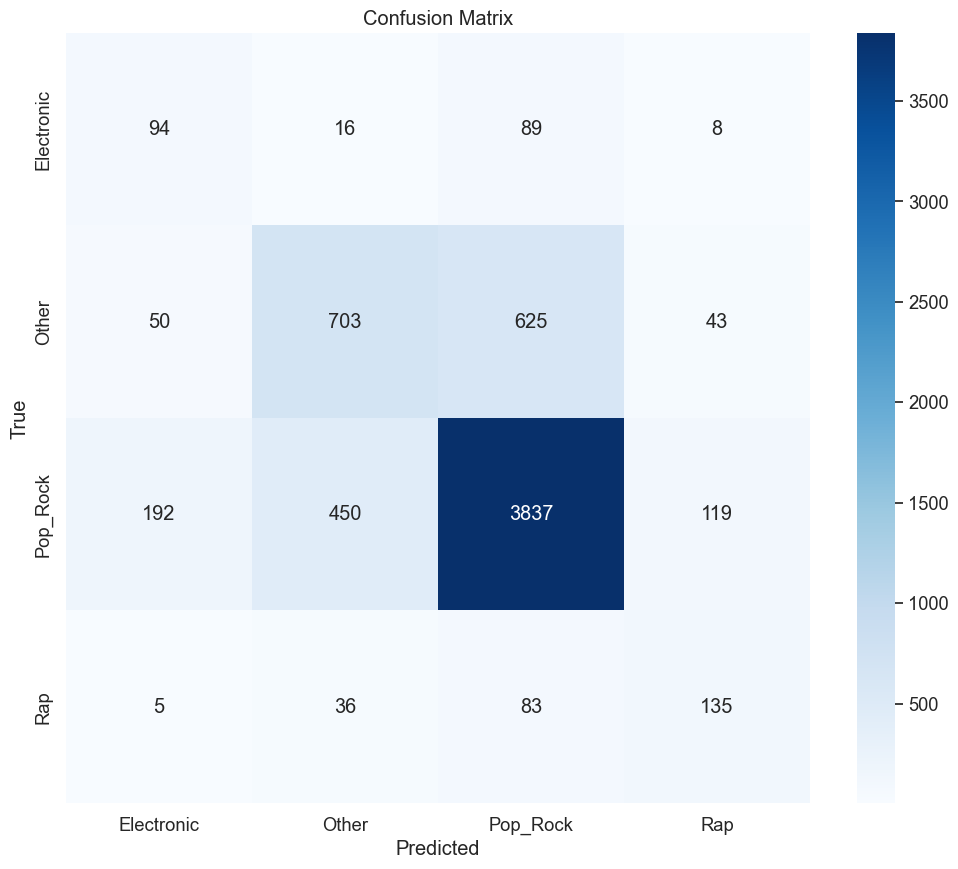

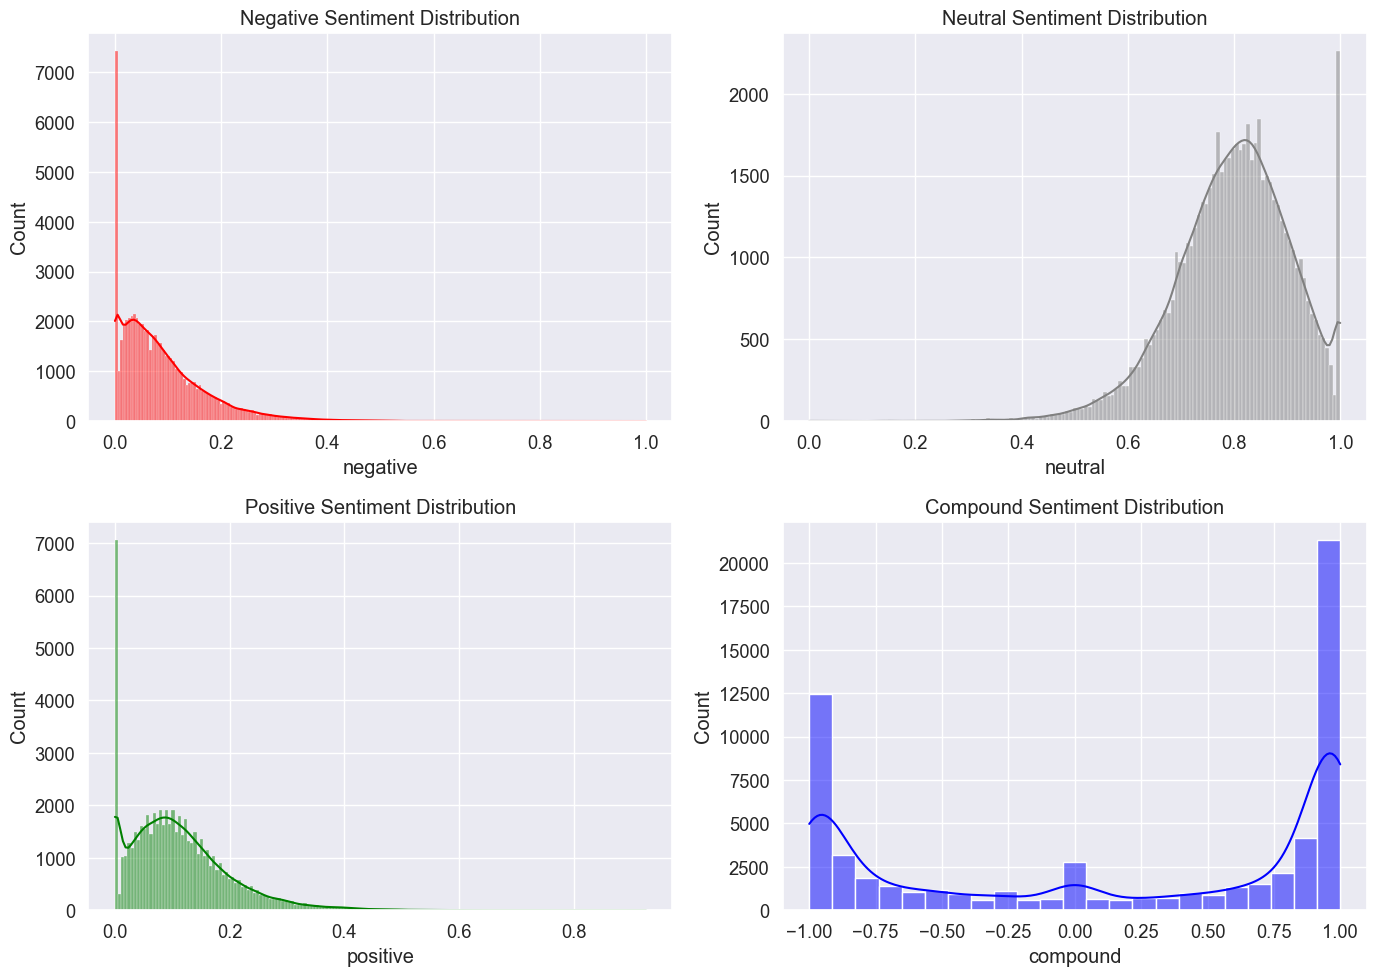

In [6]:
# Initialize with a limited sample size
analyzer = LyricsAnalyzer(
    matches_file='mxm_779k_matches.txt', 
    train_file='mxm_dataset_train.txt'#,
    #sample_size=50000  # uncomment when run locally
)

# Run the analysis
results = analyzer.run_full_analysis(max_test_samples=None)
#results = analyzer.run_full_analysis()

Plotting sentiment distribution for 31978 songs in Pop_Rock genre


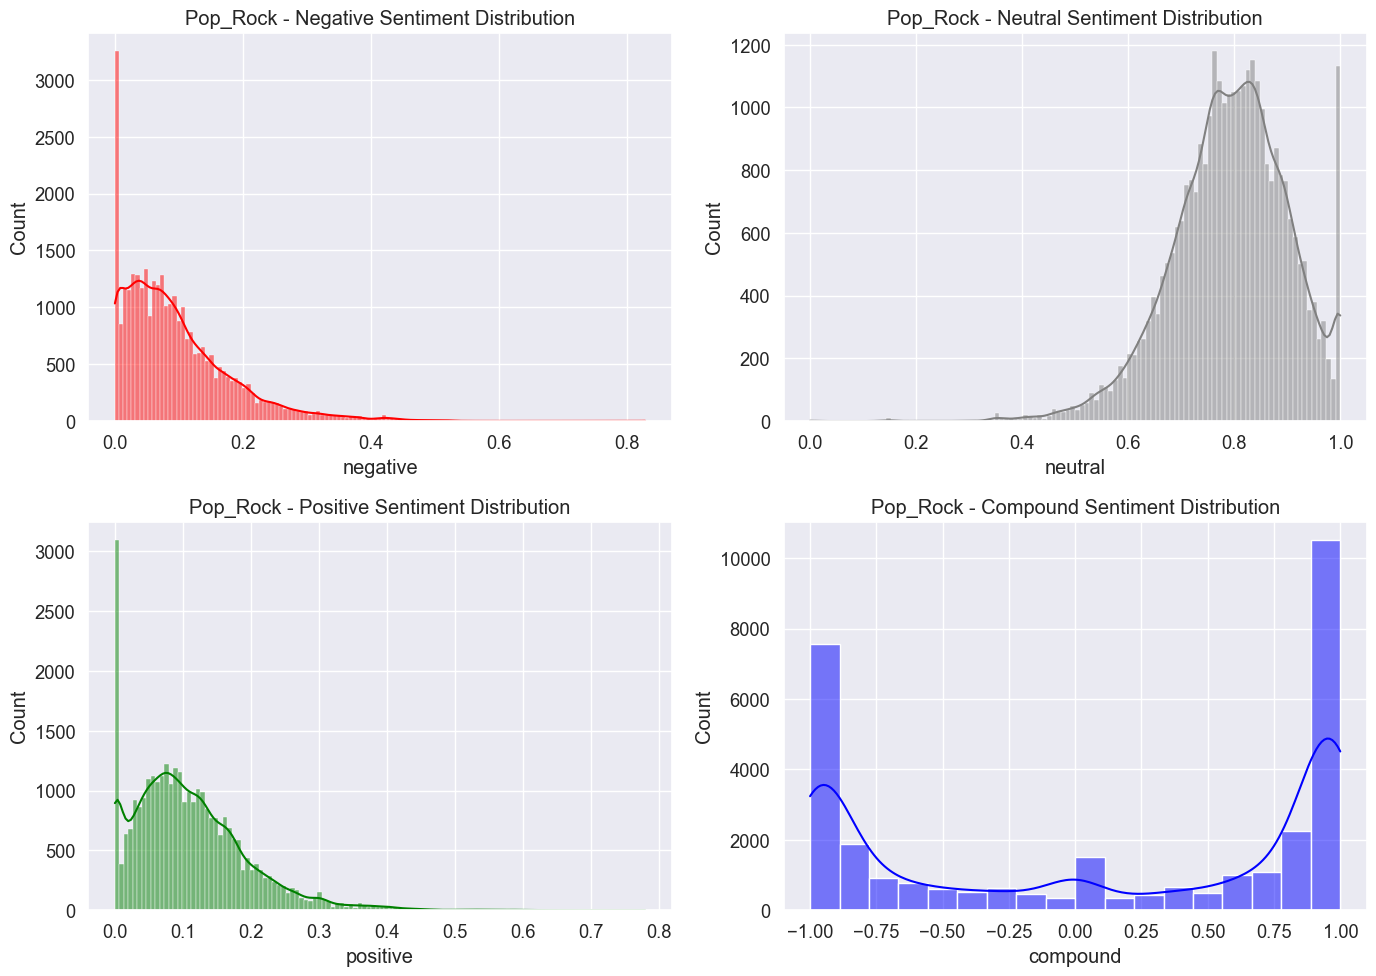

Plotting sentiment distribution for 2217 songs in Rap genre


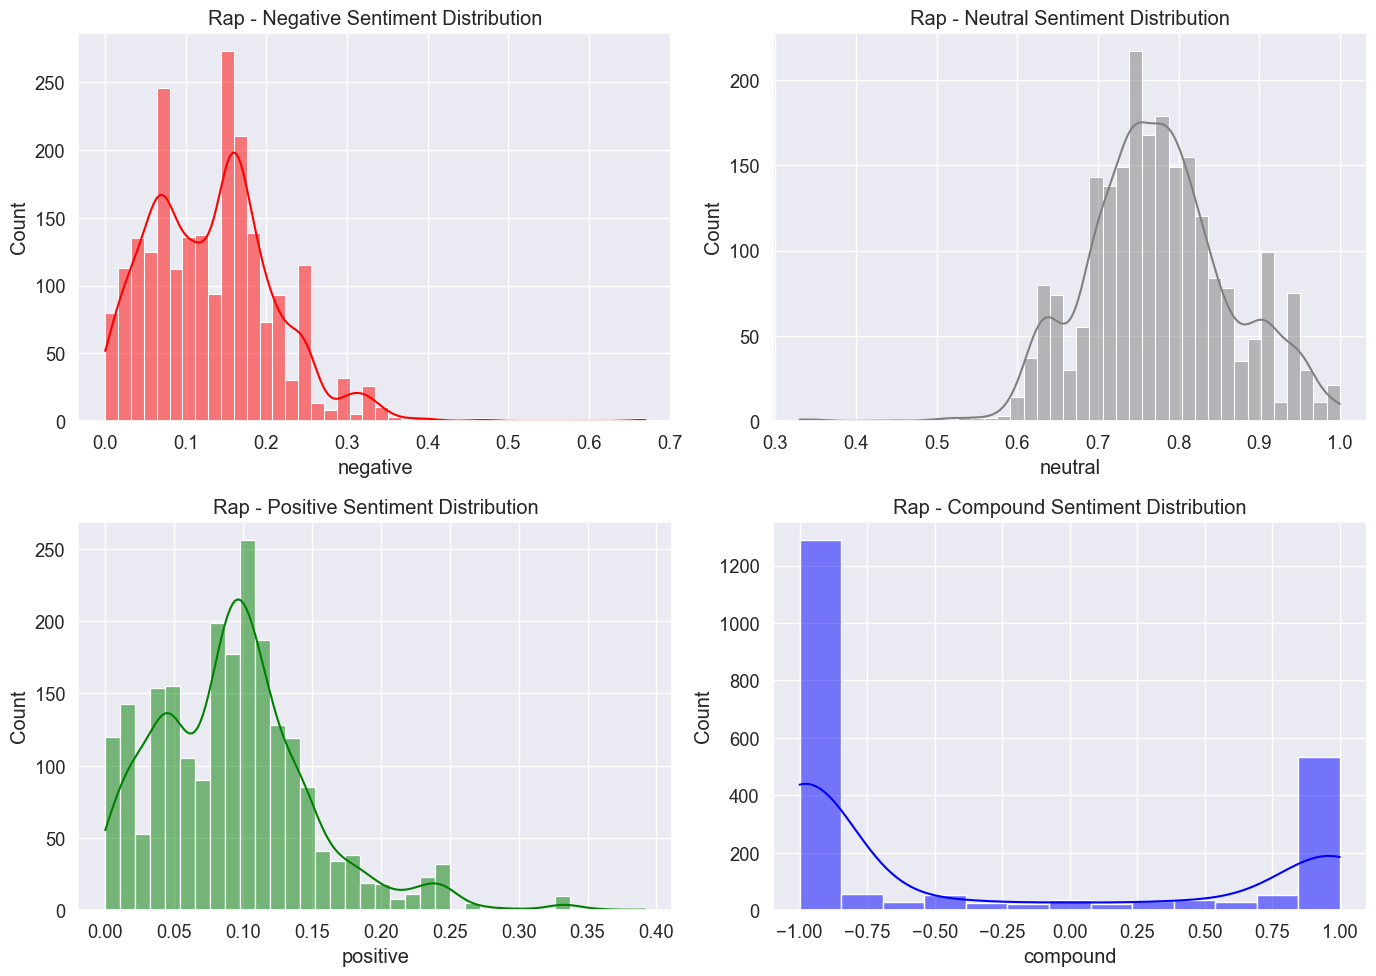

Plotting sentiment distribution for 2450 songs in Electronic genre


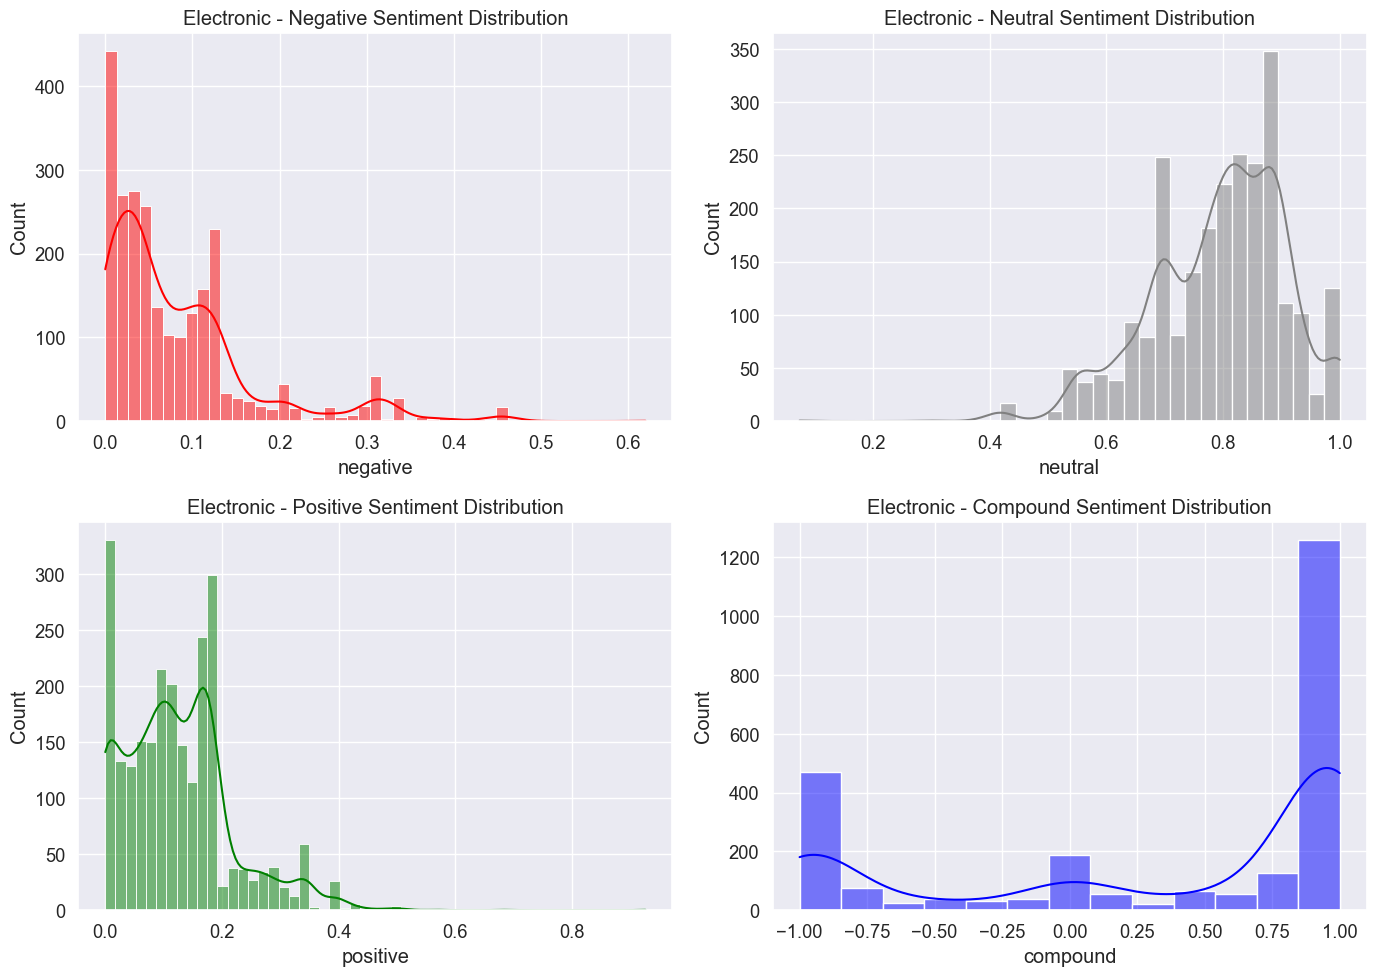

Plotting sentiment distribution for 11854 songs in Other genre


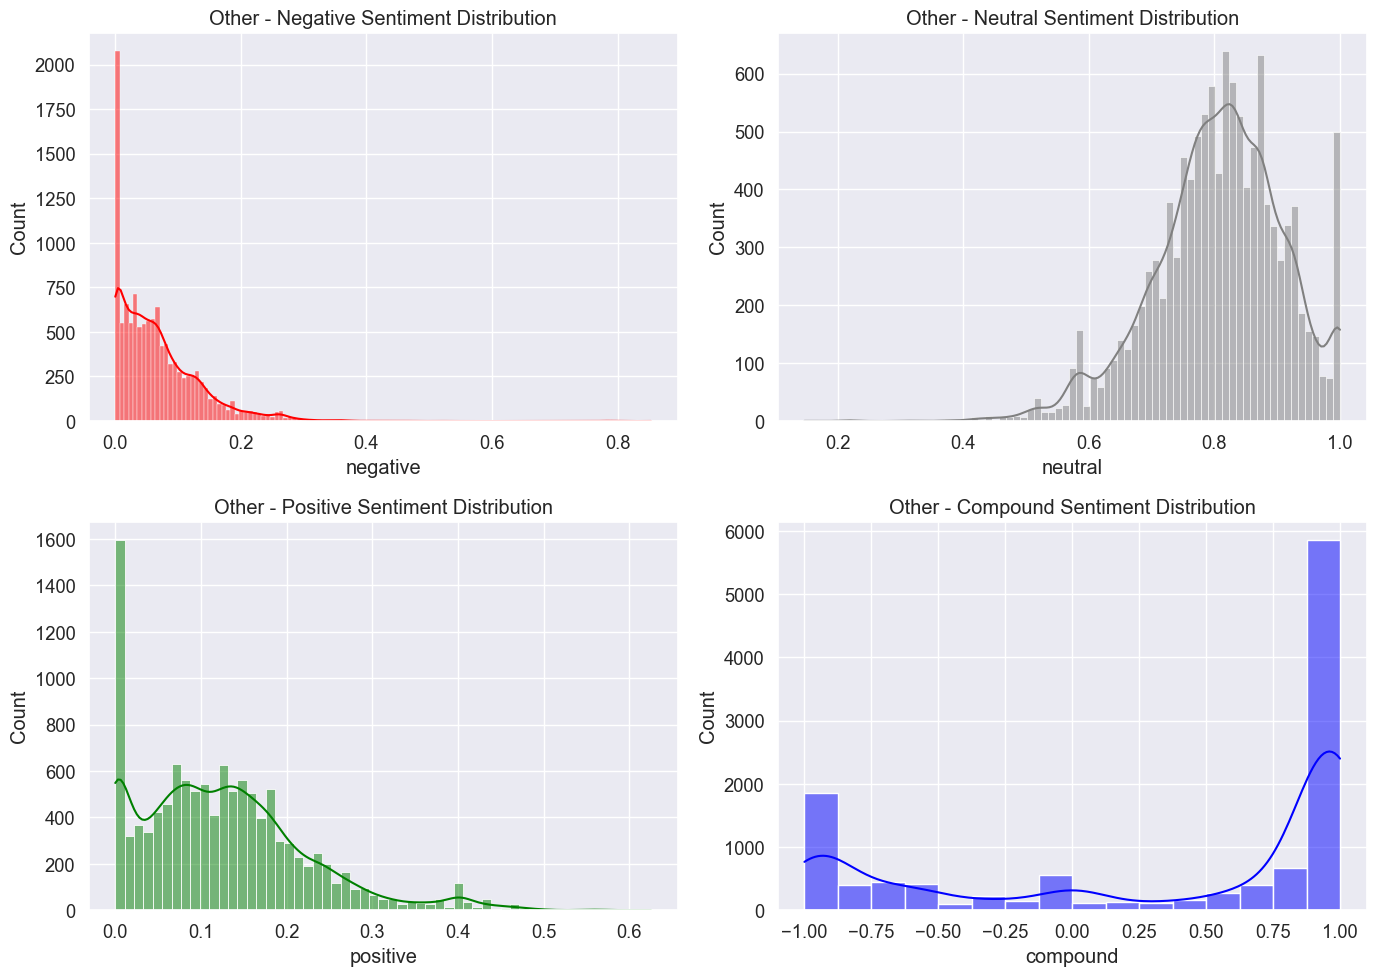

In [7]:
# Target genres
target_genres = ['Pop_Rock', 'Rap', 'Electronic', 'Other']
# Get the data from your results
merged_data = results['merged_data_with_genre']
sentiment_df = results['sentiment']

# Plot sentiment distribution for each genre
for genre in target_genres:
    fig, axs = analyzer.plot_genre_sentiment_distribution(genre, sentiment_df, merged_data)
    if fig:
        plt.figure(fig.number)
        plt.show()

Merged data contains 62882 songs.
Analyzing 6 songs in the ABBA genre
Analyzing 25 songs in the Nirvana genre
Analyzing 18 songs in the Taylor Swift genre
Analyzing 21 songs in the Michael Jackson genre
Analyzing 21 songs in the Eminem genre
Analyzing 40 songs in the Bob Dylan genre
Analyzing 10 songs in the Joy Division genre
Analyzing 10 songs in the Radiohead genre
Analyzing 13 songs in the The Smiths genre
Analyzing 8 songs in the Lady Gaga genre
Analyzing 12 songs in the Linkin Park genre
Analyzing 20 songs in the Seal genre
Analyzing 40 songs in the Frank Sinatra genre


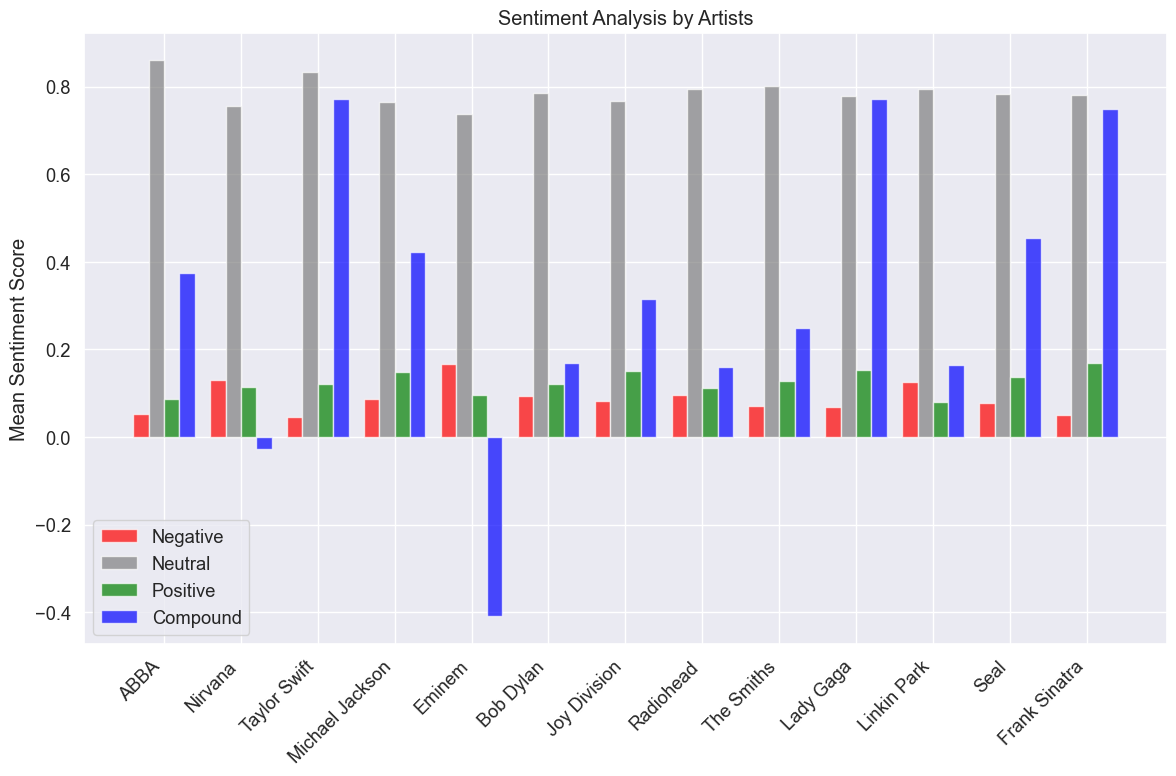

In [8]:
# Example of comparing genres
genre_mapping = {
    'ABBA': ['ABBA'],
    'Nirvana': ['Nirvana'],
    'Taylor Swift': ['Taylor Swift'],
    'Michael Jackson': ['Michael Jackson'],
    'Eminem': ['Eminem'],
    'Bob Dylan': ['Bob Dylan'],
    'Joy Division': ['Joy Division'],
    'Radiohead': ['Radiohead'],
    'The Smiths': ['The Smiths'],
    'Lady Gaga': ['Lady Gaga'],
    'Linkin Park': ['Linkin Park'],
    'Seal': ['Seal'],
    'Frank Sinatra': ['Frank Sinatra']
}

genre_stats = analyzer.compare_genres(genre_mapping)
analyzer.plot_sentiment_by_genre(genre_stats).show()

In [9]:
results['timers']

{'merge_data': [3.460765999996511],
 'sentiment': [48.90644070000053],
 'training': [171.4973847000001]}

In [10]:
results['merged_data'].describe(include='all')

,track_id,mxm_track_id,word_counts,msd_track_id,msd_artist_name,msd_title,mxm_artist_name,mxm_title,genre
count,62882,62882,62882,62882,62882,62882,62882,62882,32425
unique,50000,50000,49720,62882,13255,50373,11325,44133,21
top,TRQIKXA128F92E0D38,1448646,"{'i': 6, 'the': 7, 'you': 24, 'to': 7, 'and': ...",TRZZZYV128F92E996D,Jimi Hendrix,Intro,Frank Sinatra,Intro,Pop_Rock
freq,19,19,19,1,59,72,90,56,22988


In [11]:
results['merged_data_with_genre'].describe(include='all')

,track_id,mxm_track_id,word_counts,msd_track_id,msd_artist_name,msd_title,mxm_artist_name,mxm_title,genre,original_genre
count,32425,32425,32425,32425,32425,32425,32425,32425,32425,32425
unique,27600,27600,27507,32425,7945,27714,7404,25228,4,21
top,TRPLQCY128F932B597,8329787,"{'in': 3, 'all': 1, 'was': 2, 'es': 3, 'du': 6...",TRZZZYV128F92E996D,Jimi Hendrix,Intro,Jimi Hendrix,Intro,Pop_Rock,Pop_Rock
freq,18,18,18,1,47,37,51,32,22988,22988


In [12]:
results['sentiment'].describe(include='all')

,track_id,artist,title,negative,neutral,positive,compound
count,62882,62882,62882,62882.000000,62882.000000,62882.000000,62882.000000
unique,50000,13255,50373,NaN,NaN,NaN,NaN
top,TRQIKXA128F92E0D38,Jimi Hendrix,Intro,NaN,NaN,NaN,NaN
freq,19,59,72,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,0.088999,0.799932,0.111037,0.156522
std,NaN,NaN,NaN,0.083320,0.109176,0.087838,0.819579
min,NaN,NaN,NaN,0.000000,0.000000,0.000000,-1.000000
25%,NaN,NaN,NaN,0.028000,0.733000,0.047000,-0.822500
50%,NaN,NaN,NaN,0.068000,0.807000,0.098000,0.476700
75%,NaN,NaN,NaN,0.126000,0.875000,0.156000,0.963300


# Problem description

# Workbook Setup

# Pre-processing

# Analysis